# NYC Taxi Duration Prediction
In this competition, Kaggle is challenging you to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables. http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml



## 1. Data Exploration
In this section, I would explore the different characteristics of this datasets and use data visualization to better understand the underlying pattern of the dataset. 

First we need to import the necessary Python libraries.

In [1]:
import pandas as pd  #pandas for using dataframe and reading csv 
import numpy as np   #numpy for vector operations and basic maths 
#import simplejson    #getting JSON in simplified format
import urllib        #for url stuff
#import gmaps       #for using google maps to visulalize places on maps
import re            #for processing regular expressions
import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
import scipy         #for other dependancies
from sklearn.cluster import KMeans # for doing K-means clustering
from haversine import haversine # for calculating haversine distance
import math          #for basic maths operations
import seaborn as sns #for making plots
import matplotlib.pyplot as plt # for plotting
import os  # for os commands
# from scipy.misc import imread, imresize, imsave  # for plots 
# import plotly.plotly as py
# import plotly.graph_objs as go
# import plotly
# from bokeh.palettes import Spectral4
# from bokeh.plotting import figure, output_notebook, show
from IPython.display import HTML
from matplotlib.pyplot import *
from matplotlib import cm
from matplotlib import animation
import io
import base64
# output_notebook()
# plotly.offline.init_notebook_mode() # run at the start of every ipython notebook
# plt.rcParams['figure.figsize'] = [16, 10]

The next step is to import data set from Kaggle.com using Pandas and preview the training dataset.

In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Data Field Description:
* **id** - a unique identifier for each trip
* **vendor_id** - a code indicating the provider associated with the trip record
* **pickup_datetime** - date and time when the meter was engaged
* **dropoff_datetime** - date and time when the meter was disengaged
* **passenger_count** - the number of passengers in the vehicle (driver entered value)
* **pickup_longitude** - the longitude where the meter was engaged
* **pickup_latitude** - the latitude where the meter was engaged
* **dropoff_longitude** - the longitude where the meter was disengaged
* **dropoff_latitude** - the latitude where the meter was disengaged
* **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the * vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* **trip_duration** - duration of the trip in seconds

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


From this data summary we can understand some basic statistics of the data. In the 'trip_duration' column, we can see a minimum of 1 second and a maximum of 3526282 second (about 90 hours). Clearly we should not include trip like these since it will decrease our prediction model's accuracy. In the next section, I will attempt to remove these outliers to improve the quality of the dataset.

We also need to check whether this dataset is valid by checking if the IDs are unique.

In [4]:
# checking if Ids are unique, 
train_data = train_df.copy()
print("Number of columns and rows and columns are {} and {} respectively.".format(train_data.shape[1], train_data.shape[0]))
if train_data.id.nunique() == train_data.shape[0]:
    print("Train ids are unique")
print("Number of Nulls: {}.".format(train_data.isnull().sum().sum()))
end = time.time()

Number of columns and rows and columns are 11 and 1458644 respectively.
Train ids are unique
Number of Nulls: 0.


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


## 2. Data Preparation
In this section I will clean up the dataset, expand the features, and incorporate weather data.


In [6]:
train = train_df.copy()
test = test_df.copy()

### 2.1 Data Cleaning
From previous section we learn that some trips are 1 sec and some trips are as long as 90 hours. Obviously we want to exclude these outliers before feeding them into the training algorithm. In order to remove those trips, I decided to remove any trips that is 2 standard deviations from the mean.

In [7]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
print('mean: ', m)
print('std: ', s)
print(len(train['trip_duration']))
train = train[train['trip_duration'] <= m + 2 * s]
train = train[train['trip_duration'] >= m - 2 * s]
print(len(train['trip_duration']))

mean:  959.4922729603659
std:  5237.429929188888
1458644
1456540


We also need to remove trips that are going in and out of New York City, since we are only concerned with the trips within the city boundary. The NYC city borders are:

```
long_border = (-74.04, -73.75)
lat_border = (40.63, 40.85)
```

From previous section we can see that some trip's pick ups or drop offs are outside of the city zone. We will remove these trips.

In [8]:
long_border = (-74.04, -73.75)
lat_border = (40.63, 40.85)
train = train[train['pickup_longitude'] >= long_border[0]]
train = train[train['pickup_longitude'] <= long_border[1]]

train = train[train['pickup_latitude'] >= lat_border[0]]
train = train[train['pickup_latitude'] <= lat_border[1]]

train = train[train['dropoff_longitude'] >= long_border[0]]
train = train[train['dropoff_longitude'] <= long_border[1]]

train = train[train['dropoff_latitude'] >= lat_border[0]]
train = train[train['dropoff_latitude'] <= lat_border[1]]

print(len(train))

1437693


### 2.2 Feature Extraction
There are several different ways to extract more features from this data set. I will describe each approach below.

#### 2.2.1 Pickup Datetime
We can extract more information from the `pickup_datetime` feature from the origianl dataset. For example, we can extract the hour in day, the day in week, the date, the day in month, and the month, etc. 

In [9]:
# transform to pandas datetime
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

# hour in day
train.loc[:, 'hour'] = train['pickup_datetime'].dt.hour
test.loc[:, 'hour'] = test['pickup_datetime'].dt.hour

# day of week
train.loc[:, 'day_of_week'] = train['pickup_datetime'].dt.dayofweek
test.loc[:, 'day_of_week'] = test['pickup_datetime'].dt.dayofweek

# date
train.loc[:, 'date'] = train['pickup_datetime'].dt.date
test.loc[:, 'date'] = test['pickup_datetime'].dt.date

# # time in day
# train.loc[:, 'time_of_day'] = train['pickup_datetime'].dt.time
# test.loc[:, 'time_of_day'] = test['pickup_datetime'].dt.time

# day of month
train.loc[:, 'day_of_month'] = train['pickup_datetime'].dt.day
test.loc[:, 'day_of_month'] = test['pickup_datetime'].dt.day

# month
train.loc[:, 'month'] = train['pickup_datetime'].dt.month
test.loc[:, 'month'] = test['pickup_datetime'].dt.month

train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,hour,day_of_week,date,day_of_month,month
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,17,0,2016-03-14,14,3
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,0,6,2016-06-12,12,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,11,1,2016-01-19,19,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,19,2,2016-04-06,6,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,13,5,2016-03-26,26,3


#### 2.2.2 Trip Distance
We can also calculate the travel distance for each trip based on the pickup and dropoff coordinates. To compute the distance between two coordinates, we can compute the haversine distance. Since the majority of the trips will be within Manhattan area, we could also compute the Manhattan distance between the pickup and dropoff to better represent real-life travel distance.

In [10]:
def haversine_dist(lat1, lng1, lat2, lng2):
    return haversine((lat1, lng1), (lat2, lng2))

def manhattan_dist(lat1, lng1, lat2, lng2):
    a = haversine_dist(lat1, lng1, lat1, lng2)
    b = haversine_dist(lat1, lng1, lat2, lng1)
    return a+b


In [11]:
print(haversine_dist(40.63, -74.04, 40.85, -73.75))
print(manhattan_dist(40.63, -74.04, 40.85, -73.75))

34.574232315938104
48.9357456227728


In [12]:
haversine_array = np.vectorize(haversine_dist)
manhattan_array = np.vectorize(manhattan_dist)
train.loc[:, 'haversine_dist'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'manhattan_dist'] = manhattan_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'haversine_dist'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'manhattan_dist'] = manhattan_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,hour,day_of_week,date,day_of_month,month,haversine_dist,manhattan_dist
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,17,0,2016-03-14,14,3,1.499,1.735
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,0,6,2016-06-12,12,6,1.806,2.431
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,11,1,2016-01-19,19,1,6.385,8.204
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,19,2,2016-04-06,6,4,1.485,1.661
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,13,5,2016-03-26,26,3,1.189,1.199


#### 2.2.3 Average Speed
A good way to measure traffic impact on taxi trips is to compute taxi trips average speed. A rough estimate of the speed would be the distance divided by the trip duration. In this case, we have two representation of the distance. Thus, we can plot these two presentation of speed over the course of hours in a day, and days in a week, and months in a year.

In [13]:
train.loc[:, 'avg_speed_h'] = 3600 * train['haversine_dist'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 3600 * train['manhattan_dist'] / train['trip_duration']
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,hour,day_of_week,date,day_of_month,month,haversine_dist,manhattan_dist,avg_speed_h,avg_speed_m
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,17,0,2016-03-14,14,3,1.499,1.735,11.856,13.731
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,0,6,2016-06-12,12,6,1.806,2.431,9.804,13.197
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,11,1,2016-01-19,19,1,6.385,8.204,10.822,13.904
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,19,2,2016-04-06,6,4,1.485,1.661,12.466,13.941
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,13,5,2016-03-26,26,3,1.189,1.199,9.837,9.927


#### 2.2.4 Cluster Analysis
We could use k-means clustering algorithm to identify the different neighborhoods in NYC. Taxi going from one neighborhood to another might affect the travel duration. For example, trips between midtown Manhattan and lower Manhattan might be longer than trips between harlem and upper east side Manhattan.

I cluster the pickup and dropoff coordinates into 50 clusters. 

In [14]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge

In [15]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=50, batch_size=10000).fit(coords[sample_ind])

In [16]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

#### 2.2.5 Weather Data
I will incorporate the weather data into this competition.

In [17]:
weather_df = pd.read_csv('data/weather_data_nyc_centralpark_2016.csv')
weather_df.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38.000,0.00,0.0,0
1,2-1-2016,40,32,36.000,0.00,0.0,0
2,3-1-2016,45,35,40.000,0.00,0.0,0
3,4-1-2016,36,14,25.000,0.00,0.0,0
4,5-1-2016,29,11,20.000,0.00,0.0,0


In [18]:
weather = weather_df.copy()

In [19]:
weather.date = pd.to_datetime(weather.date, dayfirst=True)
weather.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,2016-01-01,42,34,38.000,0.00,0.0,0
1,2016-01-02,40,32,36.000,0.00,0.0,0
2,2016-01-03,45,35,40.000,0.00,0.0,0
3,2016-01-04,36,14,25.000,0.00,0.0,0
4,2016-01-05,29,11,20.000,0.00,0.0,0


In [20]:
weather['precipitation'] = np.where(weather['precipitation']=='T', '0.00', weather['precipitation'])
weather['precipitation'] = list(map(float, weather['precipitation']))

In [21]:
weather['snow fall'] = np.where(weather['snow fall']=='T', '0.00', weather['snow fall'])
weather['snow fall'] = list(map(float, weather['snow fall']))

In [22]:
weather['snow depth'] = np.where(weather['snow depth']=='T', '0.00', weather['snow depth'])
weather['snow depth'] = list(map(float, weather['snow depth']))

In [23]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [24]:
train = pd.merge(train, weather[['date', 'maximum temperature', 'minimum temperature', 'average temperature', 'precipitation', 'snow fall', 'snow depth']], on='date', how='left')
test = pd.merge(test, weather[['date', 'maximum temperature', 'minimum temperature', 'average temperature', 'precipitation', 'snow fall', 'snow depth']], on='date', how='left')

In [25]:
train.shape, test.shape

((1437693, 28), (625134, 24))

In [26]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,avg_speed_h,avg_speed_m,pickup_cluster,dropoff_cluster,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,...,11.856,13.731,34,25,51,40,45.500,0.290,0.000,0.000
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,...,9.804,13.197,28,12,83,62,72.500,0.000,0.000,0.000
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,...,10.822,13.904,18,4,28,16,22.000,0.000,0.000,0.000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,...,12.466,13.941,29,4,48,30,39.000,0.000,0.000,0.000
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,...,9.837,9.927,19,39,55,38,46.500,0.000,0.000,0.000


In [27]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,hour,...,haversine_dist,manhattan_dist,pickup_cluster,dropoff_cluster,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,id3004672,1,2016-06-30 23:59:58,1,-73.988,40.732,-73.990,40.757,N,23,...,2.746,2.913,32,40,85,67,76.000,0.000,0.000,0.000
1,id3505355,1,2016-06-30 23:59:53,1,-73.964,40.680,-73.960,40.655,N,23,...,2.759,3.105,7,42,85,67,76.000,0.000,0.000,0.000
2,id1217141,1,2016-06-30 23:59:47,1,-73.997,40.738,-73.986,40.730,N,23,...,1.306,1.846,0,32,85,67,76.000,0.000,0.000,0.000
3,id2150126,2,2016-06-30 23:59:41,1,-73.956,40.772,-73.986,40.730,N,23,...,5.269,7.163,16,32,85,67,76.000,0.000,0.000,0.000
4,id1598245,1,2016-06-30 23:59:33,1,-73.970,40.761,-73.962,40.756,N,23,...,0.961,1.354,43,25,85,67,76.000,0.000,0.000,0.000


## 3. Data Visualization
We are asked to predict trip_duration of the test set, so we first check what kind of trips durations are present in the dataset. 


### 3.1 Trip Duration Distribution
First I plotted it on a plain scale and not on a log scale, and some of the records have very long trip durations ~100 hours. Such long trips are making all another trip invisible in the histogram on plain scale => We go ahead with the log scale. Another reason of using the log scale for visualizing trip-duration on the log scale is that this competition uses rmsle matrix so it would make sense to visualize the target variable in log scale only.

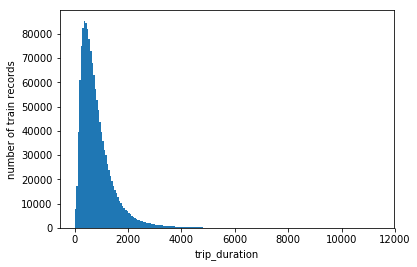

In [28]:
%matplotlib inline
# plt.rcParams['figure.figsize'] = [16, 10]
plt.hist(train['trip_duration'].values, bins=200)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

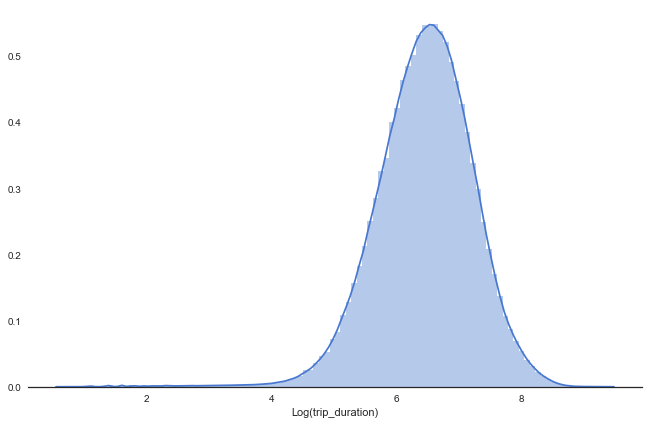

In [29]:
%matplotlib inline
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(np.log(train['trip_duration'].values + 1), axlabel = 'Log(trip_duration)', label = 'log(trip_duration)', bins = 100, color="b")
plt.show()

In [30]:
train.loc[:, 'log_trip_duration'] = np.log(train['trip_duration'].values + 1)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,avg_speed_m,pickup_cluster,dropoff_cluster,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,log_trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,...,13.731,34,25,51,40,45.500,0.290,0.000,0.000,6.122
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,...,13.197,28,12,83,62,72.500,0.000,0.000,0.000,6.498
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,...,13.904,18,4,28,16,22.000,0.000,0.000,0.000,7.662
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,...,13.941,29,4,48,30,39.000,0.000,0.000,0.000,6.064
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,...,9.927,19,39,55,38,46.500,0.000,0.000,0.000,6.078


This shows that the trip durations are an approximate Gaussian distribution. Despite some outlier trips, most trips are e^4 = 1 minute to e^8 ~ 60 minutes.

### 3.2 Number of Trips Over Time
We may also be interested in the number of trips over time, since this could reveal any seasonal trends of taxi trips in New York City. For example, taxi trips may be during Christmas holiday.

We could simply plot a timeseries line graph of the dataset.

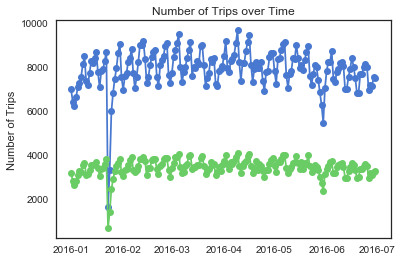

In [31]:
# plt.rcParams['figure.figsize'] = [16, 10]
plt.plot(train.groupby('date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('date').count()[['id']], 'o-', label='test')
plt.title('Number of Trips over Time')
plt.ylabel('Number of Trips')
plt.show()

As expected, the training dataset and the test dataset behaves very similary. We can see that taxi trips are fairly consistent throughout the year, except for two serious drop in early Feb 2016 and June 2016. The drop in Feb 2016 is likely from the Taxi/Uber driver strike (https://nypost.com/2016/02/01/nyc-uber-drivers-urge-strikes-over-fare-cuts/). We could potentially remove that date's data to improve data quality.

Similarly, we could plot out the number of trips throughout the week. My expectation would be more trips over the weekdays and less on the weekends.

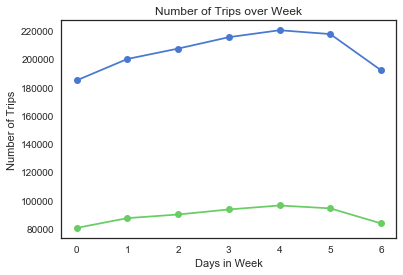

In [32]:
plt.plot(train.groupby('day_of_week').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('day_of_week').count()[['id']], 'o-', label='test')
plt.title('Number of Trips over Week')
plt.ylabel('Number of Trips')
plt.xlabel('Days in Week')
plt.show()

The result is somewhat surprising to me because it turns out Monday (0) and Sunday(6) have the lowest number of taxi trips. It is understandable that Friday(4) has the most number since people usually go out on Friday night. But I'm not entirely sure why Monday also has the lowest number.

### 3.3 Average Speed Over Time
In previous section, we calculated the rough estimate of average speed of each taxi trip. Now we can plot them over time to check how time affect the average travel speed.

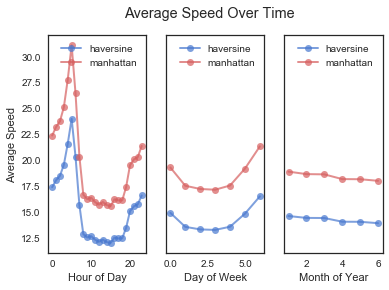

In [33]:
fig, ax = plt.subplots(ncols=3, sharey=True)

ax[0].plot(train.groupby('hour').mean()['avg_speed_h'], 'bo-', label='haversine', lw=2, alpha=0.7)
ax[0].plot(train.groupby('hour').mean()['avg_speed_m'], 'ro-', label='manhattan', lw=2, alpha=0.7)
ax[0].legend(loc='upper right')
ax[1].plot(train.groupby('day_of_week').mean()['avg_speed_h'], 'bo-', label='haversine', lw=2, alpha=0.7)
ax[1].plot(train.groupby('day_of_week').mean()['avg_speed_m'], 'ro-', label='manhattan', lw=2, alpha=0.7)
ax[1].legend(loc='upper right')
ax[2].plot(train.groupby('month').mean()['avg_speed_h'], 'bo-', label='haversine', lw=2, alpha=0.7)
ax[2].plot(train.groupby('month').mean()['avg_speed_m'], 'ro-', label='manhattan', lw=2, alpha=0.7)
ax[2].legend(loc='upper right')

ax[0].set_ylabel('Average Speed')
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
fig.suptitle('Average Speed Over Time')
plt.show()

It is clear that the hour of day has the most impact on the speed of a taxi. During day time work hours, the average speed, especially in Manhattan, is a lot lower than midnight.
The average speed over the days in a week also follows an expected trend. There are less traffic during the weekend, which leads to an increased speed.
Lastly, the average speed by month also follows an interesting trend. Although the difference is minor, we can clearly see that taxi trips in June is somewhat slower than those in Januaray. One potential explanation could be that in winter people are less likely to go out and take taxi trips, making the traffic lighter in early months of the year.

### 3.4 Coordinate Mapping
Each location is represented by a latitude and longitude, we can plot these points on a map.


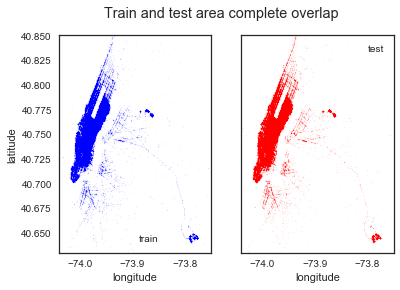

In [34]:
long_border = (-74.04, -73.75)
lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:100000], train['pickup_latitude'].values[:100000], color='blue', s=1, label='train', alpha=0.05)
ax[1].scatter(test['pickup_longitude'].values[:100000], test['pickup_latitude'].values[:100000], color='red', s=1, label='test', alpha=0.05)
fig.suptitle('Train and test area complete overlap')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(lat_border)
plt.xlim(long_border)
plt.show()

### 3.5 Neighborhoods Visualization
From previous section, we can plot out the different neighborhoods in NYC.

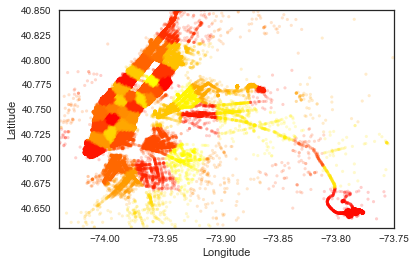

In [35]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], s=10, lw=0,
           c=train.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
ax.set_xlim(long_border)
ax.set_ylim(lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [36]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,avg_speed_m,pickup_cluster,dropoff_cluster,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,log_trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,...,13.731,34,25,51,40,45.500,0.290,0.000,0.000,6.122
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,...,13.197,28,12,83,62,72.500,0.000,0.000,0.000,6.498
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,...,13.904,18,4,28,16,22.000,0.000,0.000,0.000,7.662
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,...,13.941,29,4,48,30,39.000,0.000,0.000,0.000,6.064
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,...,9.927,19,39,55,38,46.500,0.000,0.000,0.000,6.078


### 3.6 Weather Trend

Here we plot out the temperature and precipitation of New York City in the first six months of 2016.

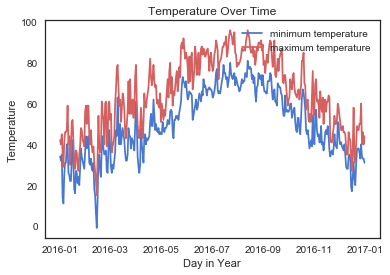

In [37]:
plt.plot(weather.groupby('date').mean()['minimum temperature'], 'b-', label='minimum temperature')
plt.plot(weather.groupby('date').mean()['maximum temperature'], 'r-', label='maximum temperature')
plt.title('Temperature Over Time')
plt.ylabel('Temperature')
plt.xlabel('Day in Year')
plt.legend(loc='upper right')
plt.show()

## 4. Taxi Trip Duration Prediction
In this section, I will attempt different approaches to predict the duration of each taxi trips given the pickup location, dropoff location and time.

In [38]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

### 4.1 Create Dummy Variable
We use one hot encoding to change categorical data such as `pickup_cluster`, `dropoff_cluster`, `passenger_count`, `vendor_id` into indicator variables. 

In [39]:
vendor_train = pd.get_dummies(train['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test = pd.get_dummies(test['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(train['passenger_count'], prefix='pc', prefix_sep='_')
passenger_count_test = pd.get_dummies(test['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
cluster_pickup_train = pd.get_dummies(train['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_pickup_test = pd.get_dummies(test['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_dropoff_train = pd.get_dummies(train['dropoff_cluster'], prefix='d', prefix_sep='_')
cluster_dropoff_test = pd.get_dummies(test['dropoff_cluster'], prefix='d', prefix_sep='_')

month_train = pd.get_dummies(train['month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test['month'], prefix='m', prefix_sep='_')
dom_train = pd.get_dummies(train['day_of_month'], prefix='dom', prefix_sep='_')
dom_test = pd.get_dummies(test['day_of_month'], prefix='dom', prefix_sep='_')
hour_train = pd.get_dummies(train['hour'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test['hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(train['day_of_week'], prefix='dow', prefix_sep='_')
dow_test = pd.get_dummies(test['day_of_week'], prefix='dow', prefix_sep='_')

In [40]:
vendor_train.shape, vendor_test.shape

((1437693, 2), (625134, 2))

In [41]:
passenger_count_train.shape, passenger_count_test.shape

((1437693, 8), (625134, 8))

In [42]:
store_and_fwd_flag_train.shape, store_and_fwd_flag_test.shape

((1437693, 2), (625134, 2))

In [43]:
cluster_pickup_train.shape, cluster_pickup_test.shape

((1437693, 50), (625134, 50))

In [44]:
cluster_dropoff_train.shape, cluster_dropoff_test.shape

((1437693, 50), (625134, 50))

In [45]:
month_train.shape, month_test.shape

((1437693, 6), (625134, 6))

In [46]:
dom_train.shape, dom_test.shape

((1437693, 31), (625134, 31))

In [47]:
hour_train.shape, hour_test.shape

((1437693, 24), (625134, 24))

In [48]:
dow_train.shape, dow_train.shape

((1437693, 7), (1437693, 7))

In [49]:
passenger_count_test = passenger_count_test.drop(['pc_9'], axis=1)

In [50]:
passenger_count_train = passenger_count_train.drop(['pc_7'], axis = 1)

Before we can combine all the dummy variables with the continuous variables from the origian dataset to create our training dataset, we need to drop all the categorical variables from the original training dataset.

In [51]:
train = train.drop(['id', 'vendor_id', 'passenger_count', 'store_and_fwd_flag', 'month', 'day_of_month', 
                    'hour', 'day_of_week'], axis = 1)
test_ids = test['id']
test = test.drop(['id', 'vendor_id', 'passenger_count', 'store_and_fwd_flag', 'month', 'day_of_month', 
                  'hour', 'day_of_week'], axis = 1)

In [52]:
train = train.drop(['dropoff_datetime', 'avg_speed_h', 'avg_speed_m', 'trip_duration'], axis=1)

In [53]:
train.shape, test.shape

((1437693, 17), (625134, 16))

In [54]:
train.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,date,haversine_dist,manhattan_dist,pickup_cluster,dropoff_cluster,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,log_trip_duration
0,2016-03-14 17:24:55,-73.982,40.768,-73.965,40.766,2016-03-14,1.499,1.735,34,25,51,40,45.500,0.290,0.000,0.000,6.122
1,2016-06-12 00:43:35,-73.980,40.739,-73.999,40.731,2016-06-12,1.806,2.431,28,12,83,62,72.500,0.000,0.000,0.000,6.498
2,2016-01-19 11:35:24,-73.979,40.764,-74.005,40.710,2016-01-19,6.385,8.204,18,4,28,16,22.000,0.000,0.000,0.000,7.662
3,2016-04-06 19:32:31,-74.010,40.720,-74.012,40.707,2016-04-06,1.485,1.661,29,4,48,30,39.000,0.000,0.000,0.000,6.064
4,2016-03-26 13:30:55,-73.973,40.793,-73.973,40.783,2016-03-26,1.189,1.199,19,39,55,38,46.500,0.000,0.000,0.000,6.078


In [55]:
train = train.drop(['pickup_datetime', 'date', 'snow depth'], axis=1)
test = test.drop(['pickup_datetime', 'date', 'snow depth'], axis=1)
train.shape, test.shape

((1437693, 14), (625134, 13))

In [56]:
train_master = pd.concat([train, 
                          vendor_train, 
                          passenger_count_train, 
                          store_and_fwd_flag_train,
                          cluster_pickup_train,
                          cluster_dropoff_train,
                          month_train,
                          dom_train,
                          hour_train,
                          dow_train
                         ], axis=1)

In [57]:
test_master = pd.concat([test, 
                          vendor_test, 
                          passenger_count_test, 
                          store_and_fwd_flag_test,
                          cluster_pickup_test,
                          cluster_dropoff_test,
                          month_test,
                          dom_test,
                          hour_test,
                          dow_test
                         ], axis=1)

In [58]:
train_master.shape, test_master.shape

((1437693, 193), (625134, 192))

### 4.2 Create a Train Test split among the training dataset
Train test split.

In [59]:
Train, Test = train_test_split(train_master[0:100000], test_size = 0.2)

In [60]:
X_train = Train.drop(['log_trip_duration'], axis = 1)
y_train = Train['log_trip_duration']
X_test = Test.drop(['log_trip_duration'], axis = 1)
y_test = Test['log_trip_duration']

y_test = y_test.reset_index().drop('index', axis = 1)
y_train = y_train.reset_index().drop('index', axis = 1)

Create XGBoost matrice that will be used to train the model using XGBoost. 

In [61]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
dtest = xgb.DMatrix(test_master)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

### 4.3 XGBoost - Training the Model and Testing the Accuracy
First we need to set the parameters for XGBoost. There are a three different setting parameters: general parameters, booster parameters, and task parameters.

In [62]:
# md = [6]
# lr = [0.1, 0.3]
# mcw = [20, 25, 30]
# for m in md:
#     for l in lr:
#         for n in mcw:
#             xgb_pars = {
#                 'min_child_weight': n, 
#                 'eta': l, 
#                 'colsample_bytree': 0.9, 
#                 'max_depth': m,
#                 'subsample': 0.9,
#                 'lambda': 1.,
#                 'nthread': -1, 
#                 'booster': 'gbtree',
#                 'silent': 1,
#                 'eval_metric': 'rmse',
#                 'objective': 'reg:linear'
#                        }
#             model = xgb.train(xgb_pars, dtrain, 50, watchlist, early_stopping_rounds=10, verbose_eval=1)
#             print('m, l, n: ', m, l, n)

The best parameters are m = 6, l = 0.3, n = 30

In [63]:
xgb_pars = {
            'min_child_weight': 30, 
            'eta': 0.3, 
            'colsample_bytree': 0.9, 
            'max_depth': 6,
            'subsample': 0.9,
            'lambda': 1.,
            'nthread': -1, 
            'booster': 'gbtree',
            'silent': 1,
            'eval_metric': 'rmse',
            'objective': 'reg:linear'
           }
model = xgb.train(xgb_pars, dtrain, 50, watchlist, early_stopping_rounds=10, verbose_eval=1)

[0]	train-rmse:4.21176	valid-rmse:4.2126
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:2.96616	valid-rmse:2.96783
[2]	train-rmse:2.10079	valid-rmse:2.10317
[3]	train-rmse:1.50367	valid-rmse:1.50706
[4]	train-rmse:1.09774	valid-rmse:1.10205
[5]	train-rmse:0.827971	valid-rmse:0.833391
[6]	train-rmse:0.654573	valid-rmse:0.661514
[7]	train-rmse:0.549003	valid-rmse:0.556934
[8]	train-rmse:0.488075	valid-rmse:0.496596
[9]	train-rmse:0.453651	valid-rmse:0.462725
[10]	train-rmse:0.433834	valid-rmse:0.443696
[11]	train-rmse:0.422444	valid-rmse:0.432643
[12]	train-rmse:0.415425	valid-rmse:0.426017
[13]	train-rmse:0.411215	valid-rmse:0.421904
[14]	train-rmse:0.406841	valid-rmse:0.417573
[15]	train-rmse:0.404264	valid-rmse:0.415305
[16]	train-rmse:0.401668	valid-rmse:0.41313
[17]	train-rmse:0.399661	valid-rmse:0.411755
[18]	train-rmse:0.398236	valid-rmse:0.41046
[19]	train-rmse:0.39679

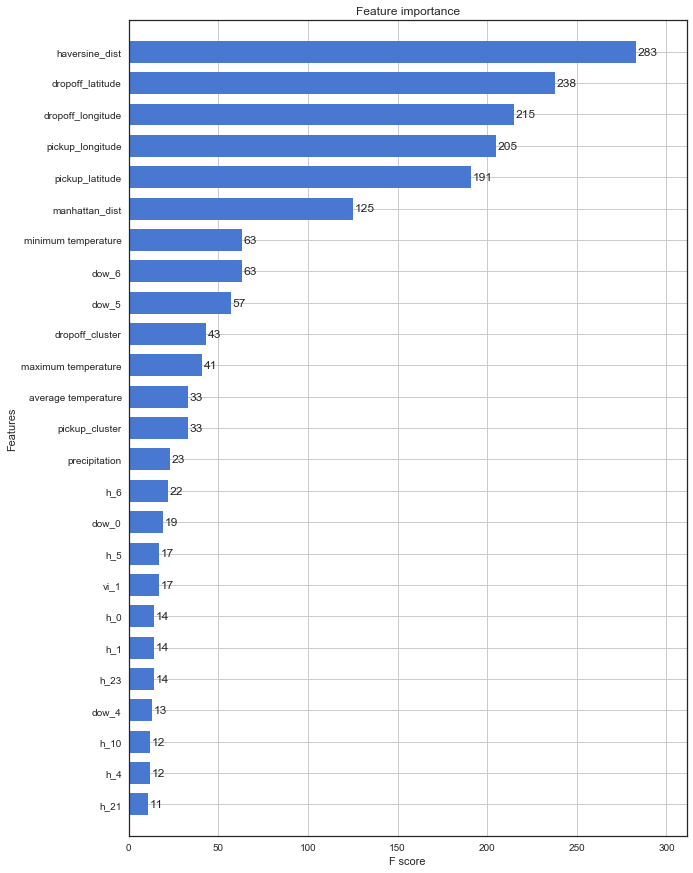

In [68]:
plt.rcParams['figure.figsize'] = [10, 15]
xgb.plot_importance(model, max_num_features=25, height=0.7)

In [65]:
pred = model.predict(dtest)
pred = np.exp(pred) -1

In [66]:
submission = pd.concat([test_ids, pd.DataFrame(pred)], axis=1)
submission.columns = ['id', 'trip_duration']
submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis=1)
submission.to_csv("submission.csv", index=False)